In [1]:
# Put the imports here, this makes it easy to create a requirements.txt file
# later, which can be used by whoever is grading us to install everything!
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from itertools import combinations


In [4]:
# Reading the CSV file into a DataFrame
file_path = './data/alzheimers_disease_data.csv'  # Replace with your file path if different
alzheimers_data = pd.read_csv(file_path)

In [5]:
internal_factors_keys = [
    "Age", "Gender", "Ethnicity", "BMI", "FamilyHistoryAlzheimers",
    "CardiovascularDisease", "Diabetes", "Depression", "Hypertension",
    "SystolicBP", "DiastolicBP", "CholesterolTotal", "CholesterolLDL",
    "CholesterolHDL", "CholesterolTriglycerides", "MMSE", "FunctionalAssessment",
    "MemoryComplaints", "BehavioralProblems", "ADL", "Confusion",
    "Disorientation", "PersonalityChanges", "DifficultyCompletingTasks",
    "Forgetfulness", "HeadInjury"
]
external_factors_keys = ["EducationLevel", "Smoking", "AlcoholConsumption",
                         "PhysicalActivity", "DietQuality", "SleepQuality"]

In [6]:
df = alzheimers_data
df.columns = df.columns.str.strip()

Logistic regression:

we need to use forward modelling selection with the usage of BIC

In [7]:
#logistic regression model with ['MemoryComplaints', 'BehavioralProblems', 'MMSE', 'ADL', 'FunctionalAssessment']

# Define the target variable (Diagnosis) and predictor variables (X)
y = alzheimers_data['Diagnosis'].astype(int)  # Ensure target variable is numeric

# You can add a constant (intercept) term to the predictor variables:
X = alzheimers_data[['MemoryComplaints', 'BehavioralProblems', 'MMSE', 'ADL', 'FunctionalAssessment']]
X_sm = sm.add_constant(X)  # Add a constant for the intercept term

# Fit the logistic regression model
model = sm.Logit(y, X_sm).fit()

print(model.summary())

# Get the BIC value for the model
bic_value = model.bic

# Print the BIC value
print(f"BIC value for the given model: {bic_value}")


Optimization terminated successfully.
         Current function value: 0.374126
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                 2149
Model:                          Logit   Df Residuals:                     2143
Method:                           MLE   Df Model:                            5
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                  0.4241
Time:                        10:13:08   Log-Likelihood:                -804.00
converged:                       True   LL-Null:                       -1396.2
Covariance Type:            nonrobust   LLR p-value:                7.292e-254
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.8610      0.231     16.684      0.000       3.407       4.315

Takes the predictors and calculates which model is the best with the use of BIC. The code below looks at the variables and adds the one with the best (lowest) BIC score. It keeps on doing this until it cannot imnprove the BIC score anymore. Then, it adds the remaining variables so you can see in the graph that the BIC score gets worse the more variables you add from that point on. 

Best combination of predictors: ['FunctionalAssessment', 'ADL', 'MemoryComplaints', 'BehavioralProblems', 'MMSE']
Best BIC: 1654.0285326599942
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                 2149
Model:                          Logit   Df Residuals:                     2143
Method:                           MLE   Df Model:                            5
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                  0.4241
Time:                        10:13:25   Log-Likelihood:                -804.00
converged:                       True   LL-Null:                       -1396.2
Covariance Type:            nonrobust   LLR p-value:                7.292e-254
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.8610      0.231     

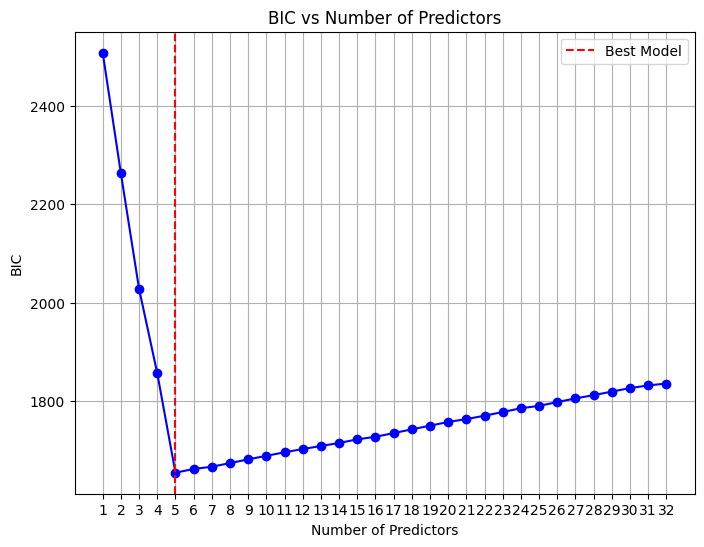

In [8]:
# Define the target variable (Diagnosis) and predictor variables 
y = alzheimers_data['Diagnosis'].astype(int)  # Ensure target variable is numeric

# Create a list of all potential predictor variables
predictors = internal_factors_keys + external_factors_keys

# Function to fit logistic regression and calculate BIC
def fit_model(X):
    X_sm = sm.add_constant(X)  # Add a constant for the intercept term
    model_sm = sm.Logit(y, X_sm).fit(disp=0)  # Fit the logistic regression model
    return model_sm.bic, model_sm  # Return the BIC value and model

# Function to print the logistic regression formula
def print_model_formula(model, predictors):
    coef = model.params
    formula = f"y = {coef.iloc[0]:.4f}"  # Intercept
    for i, predictor in enumerate(predictors):
        formula += f" + ({coef.iloc[i + 1]:.4f} * {predictor})"
    print("Logistic Regression Formula:")
    print(formula)

# Initialize lists to store the BIC values and the predictors used
bic_values = []
best_bic = float('inf')
best_model = None
selected_predictors = []
remaining_predictors = set(predictors)

# Step 1: Find the best initial predictor
best_initial_bic = float('inf')
best_initial_predictor = None

for predictor in remaining_predictors:
    X = alzheimers_data[[predictor]]
    bic, _ = fit_model(X)
    if bic < best_initial_bic:
        best_initial_bic = bic
        best_initial_predictor = predictor

# Update lists and variables after selecting the first predictor
selected_predictors.append(best_initial_predictor)
bic_values.append(best_initial_bic)
best_bic = best_initial_bic
remaining_predictors.remove(best_initial_predictor)

# Step 2: Iteratively add predictors that improve the BIC
while remaining_predictors:
    best_new_bic = float('inf')
    best_new_predictor = None

    for predictor in remaining_predictors:
        X = alzheimers_data[selected_predictors + [predictor]]
        bic, _ = fit_model(X)
        if bic < best_new_bic:
            best_new_bic = bic
            best_new_predictor = predictor

    # Check if adding the new predictor improves the BIC
    if best_new_bic < best_bic:
        best_bic = best_new_bic
        selected_predictors.append(best_new_predictor)
        bic_values.append(best_bic)
        remaining_predictors.remove(best_new_predictor)

        # Save the current best model
        X_best = alzheimers_data[selected_predictors]
        X_best_sm = sm.add_constant(X_best)
        _, best_model = fit_model(X_best)
    else:
        break  # Stop if no improvement

# Step 3: Add remaining predictors to complete the graph
for predictor in remaining_predictors:
    selected_predictors.append(predictor)
    X = alzheimers_data[selected_predictors]
    bic, _ = fit_model(X)
    bic_values.append(bic)

# Print the best combination of predictors and its BIC
print(f"Best combination of predictors: {selected_predictors[:bic_values.index(best_bic) + 1]}")
print(f"Best BIC: {best_bic}")

# Print the summary of the best model
print(best_model.summary())

# Print the logistic regression formula for the best model
print_model_formula(best_model, selected_predictors[:bic_values.index(best_bic) + 1])

# Visualization: Plot the number of predictors vs BIC values
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(bic_values) + 1), bic_values, marker='o', linestyle='-', color='b')
plt.title('BIC vs Number of Predictors')
plt.xlabel('Number of Predictors')
plt.ylabel('BIC')
plt.xticks(range(1, len(bic_values) + 1))
plt.axvline(x=bic_values.index(best_bic) + 1, color='r', linestyle='--', label='Best Model')
plt.legend()
plt.grid(True)
plt.show()


From here on, the same is done but the columns are seperated based on the ethnicity. So per column, 4 new columns are added (for ethnicity 0-3)

In [11]:
df_2 = alzheimers_data

In [12]:
#combine all predictors
all_predictors = internal_factors_keys + external_factors_keys

In [13]:
# Initialize the list
predictors_on_ethnicity = []

# Create subset columns and add their names to the list
for predictor in all_predictors:
    for ethnicity in df_2['Ethnicity'].unique():
        col_name = f'{predictor}_{ethnicity}'
        df_2[col_name] = df_2.loc[df_2['Ethnicity'] == ethnicity, predictor].fillna(0)
        predictors_on_ethnicity.append(col_name)  # Add to the list



/var/folders/1p/_qsgjt295zvdn826n1c5sy700000gn/T/ipykernel_1019/2322659114.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_2[col_name] = df_2.loc[df_2['Ethnicity'] == ethnicity, predictor].fillna(0)
/var/folders/1p/_qsgjt295zvdn826n1c5sy700000gn/T/ipykernel_1019/2322659114.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_2[col_name] = df_2.loc[df_2['Ethnicity'] == ethnicity, predictor].fillna(0)
/var/folders/1p/_qsgjt295zvdn826n1c5sy700000gn/T/ipykernel_1019/2322659114.py:8: PerformanceWarning: DataFrame is highly f

In [114]:
def write_df_to_csv(df, file_name):
    """
    Writes the provided DataFrame to a CSV file.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to write.
    file_name (str): The name of the CSV file to save the DataFrame.
    """
    df.to_csv(file_name, index=False)  # index=False prevents writing row indices
    print(f"DataFrame successfully written to {file_name}")

In [123]:
write_df_to_csv(df_2, 'analysis.csv')

DataFrame successfully written to analysis.csv


The code below fills in all the Nan in the dataframe. It does this by firstly iterating over all columns. In the column, it checks if there are any Nan. If it finds a Nan, it looks at the diagnosis of the row. Then, it takes a random value out of that column with the same diagnosis score and fills it in. 

In [128]:
#fill in the Nan by randomly replacing it by another value of that column, but checking if the 'diagnosis' value is the same of the one that it replaces it with


def random_impute_by_diagnosis(df, column, diagnosis_column='Diagnosis'):
    # Iterate over each row in the dataframe
    for idx, row in df.iterrows():
        # If the current column has a NaN value
        if pd.isna(row[column]):
            # Get the Diagnosis value of the current row
            diagnosis_value = row[diagnosis_column]
            
            # Filter the dataframe for rows with the same Diagnosis value
            subset = df[df[diagnosis_column] == diagnosis_value]
            
            # Get the non-NaN values of the current column from the subset
            non_missing_values = subset[column].dropna().values
            
            # If there are any non-NaN values to sample from
            if len(non_missing_values) > 0:
                # Randomly select a value from the non-missing values
                random_value = np.random.choice(non_missing_values)
                
                # Replace the NaN with the randomly selected value
                df.at[idx, column] = random_value
    
    # After finishing the column, print a success message
    print(f"Imputation for column '{column}' completed successfully.")
    return df


In [129]:
columns = df_2.columns
for column in columns:
    df_2 = random_impute_by_diagnosis(df_2, column)

#this took 30 minutes

Imputation for column 'PatientID' completed successfully.
Imputation for column 'Age' completed successfully.
Imputation for column 'Gender' completed successfully.
Imputation for column 'Ethnicity' completed successfully.
Imputation for column 'EducationLevel' completed successfully.
Imputation for column 'BMI' completed successfully.
Imputation for column 'Smoking' completed successfully.
Imputation for column 'AlcoholConsumption' completed successfully.
Imputation for column 'PhysicalActivity' completed successfully.
Imputation for column 'DietQuality' completed successfully.
Imputation for column 'SleepQuality' completed successfully.
Imputation for column 'FamilyHistoryAlzheimers' completed successfully.
Imputation for column 'CardiovascularDisease' completed successfully.
Imputation for column 'Diabetes' completed successfully.
Imputation for column 'Depression' completed successfully.
Imputation for column 'HeadInjury' completed successfully.
Imputation for column 'Hypertension'

In [130]:
df_3 = df_2

In [131]:
#because it took 30 minutes to make this df, it is saved to a csv file so it can easily be read again when opening up ipynb again instead of having to do this all over
write_df_to_csv(df_3, 'analysis_2.csv')

DataFrame successfully written to analysis_2.csv


In [133]:
#drop these ethnicity columns since we are already looking at them per variable
df_3.drop(columns=['Ethnicity_0'], inplace=True)
df_3.drop(columns=['Ethnicity_1'], inplace=True)
df_3.drop(columns=['Ethnicity_2'], inplace=True)
df_3.drop(columns=['Ethnicity_3'], inplace=True)


In [18]:
#drop the ethnicity column names in the list with column names
predictors_2 = predictors_on_ethnicity
predictors_2.remove("Ethnicity_0")
predictors_2.remove("Ethnicity_1")
predictors_2.remove("Ethnicity_2")
predictors_2.remove("Ethnicity_3")

ValueError: list.remove(x): x not in list

Down here is the logistic regression fit again and the BIC used to determine the best model

Best combination of predictors: ['FunctionalAssessment_3', 'FunctionalAssessment_2', 'MemoryComplaints_1', 'ADL_3', 'FunctionalAssessment_0', 'ADL_1', 'MemoryComplaints_2', 'FunctionalAssessment_1', 'ADL_2', 'ADL_0', 'MemoryComplaints_0', 'BehavioralProblems_0', 'MMSE_0', 'MMSE_2', 'MemoryComplaints_3', 'MMSE_1', 'SystolicBP_2', 'PhysicalActivity_2', 'BehavioralProblems_1', 'CholesterolLDL_2', 'DietQuality_3', 'CholesterolLDL_3', 'PersonalityChanges_0', 'CholesterolHDL_2', 'Hypertension_2', 'Hypertension_3', 'Forgetfulness_3', 'MMSE_3', 'Diabetes_3', 'DiastolicBP_2']
Best BIC: 702.6041719288762
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                 2149
Model:                          Logit   Df Residuals:                     2118
Method:                           MLE   Df Model:                           30
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                  0.8336
Tim

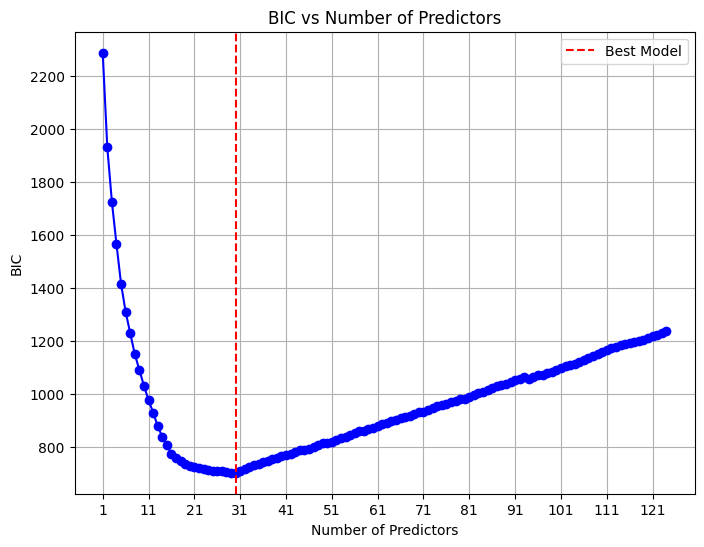

In [137]:

# Define the target variable (Diagnosis) and predictor variables 
y = df_3['Diagnosis'].astype(int)  # Ensure target variable is numeric

# Create a list of all potential predictor variables
predictors = predictors_2

"""
# Function to fit logistic regression and calculate BIC
def fit_model(X):
    X_sm = sm.add_constant(X)  # Add a constant for the intercept term
    model_sm = sm.Logit(y, X_sm).fit(disp=0)  # Fit the logistic regression model
    return model_sm.bic, model_sm  # Return the BIC value and model
"""

def fit_model(X):
    X_sm = sm.add_constant(X)  # Add a constant for the intercept term
    try:
        model_sm = sm.Logit(y, X_sm).fit(disp=0)  # Fit the logistic regression model
        return model_sm.bic, model_sm  # Return the BIC value and model
    except np.linalg.LinAlgError:  # Catch singular matrix error
        print("Singular matrix error with predictors:", X.columns)
        return np.inf, None  # Return an infinite BIC value to discard this model
    
# Function to print the logistic regression formula
def print_model_formula(model, predictors):
    coef = model.params
    formula = f"y = {coef.iloc[0]:.4f}"  # Intercept
    for i, predictor in enumerate(predictors):
        formula += f" + ({coef.iloc[i + 1]:.4f} * {predictor})"
    print("Logistic Regression Formula:")
    print(formula)

# Initialize lists to store the BIC values and the predictors used
bic_values = []
best_bic = float('inf')
best_model = None
selected_predictors = []
remaining_predictors = set(predictors)

# Step 1: Find the best initial predictor
best_initial_bic = float('inf')
best_initial_predictor = None

for predictor in remaining_predictors:
    X = df_3[[predictor]]
    bic, _ = fit_model(X)
    if bic < best_initial_bic:
        best_initial_bic = bic
        best_initial_predictor = predictor

# Update lists and variables after selecting the first predictor
selected_predictors.append(best_initial_predictor)
bic_values.append(best_initial_bic)
best_bic = best_initial_bic
remaining_predictors.remove(best_initial_predictor)

# Step 2: Iteratively add predictors that improve the BIC
while remaining_predictors:
    best_new_bic = float('inf')
    best_new_predictor = None

    for predictor in remaining_predictors:
        X = df_3[selected_predictors + [predictor]]
        bic, _ = fit_model(X)
        if bic < best_new_bic:
            best_new_bic = bic
            best_new_predictor = predictor

    # Check if adding the new predictor improves the BIC
    if best_new_bic < best_bic:
        best_bic = best_new_bic
        selected_predictors.append(best_new_predictor)
        bic_values.append(best_bic)
        remaining_predictors.remove(best_new_predictor)

        # Save the current best model
        X_best = df_3[selected_predictors]
        X_best_sm = sm.add_constant(X_best)
        _, best_model = fit_model(X_best)
    else:
        break  # Stop if no improvement

# Step 3: Add remaining predictors to complete the graph
for predictor in remaining_predictors:
    selected_predictors.append(predictor)
    X = df_3[selected_predictors]
    bic, _ = fit_model(X)
    bic_values.append(bic)

# Print the best combination of predictors and its BIC
print(f"Best combination of predictors: {selected_predictors[:bic_values.index(best_bic) + 1]}")
print(f"Best BIC: {best_bic}")

# Print the summary of the best model
print(best_model.summary())

# Print the logistic regression formula for the best model
print_model_formula(best_model, selected_predictors[:bic_values.index(best_bic) + 1])

# Visualization: Plot the number of predictors vs BIC values
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(bic_values) + 1), bic_values, marker='o', linestyle='-', color='b')
plt.title('BIC vs Number of Predictors')
plt.xlabel('Number of Predictors')
plt.ylabel('BIC')
plt.xticks(range(1, len(bic_values) + 1, 10))
plt.axvline(x=bic_values.index(best_bic) + 1, color='r', linestyle='--', label='Best Model')
plt.legend()
plt.grid(True)
plt.show()


From here on, the same is done as above. So the logistic regression is fit with the help of BIC. However, since making the dataframe with the columns seperated on ethnicity took very long, if the outputs are somehow deleted, down here is a quicker version that reads the already edited csv file in a dataframe. As you can see all the way at the bottom, the results are the same. 

In [30]:
# Reading the CSV file into a DataFrame
file_path = 'analysis_2.csv'  # Replace with your file path if different
alzheimers_data_new_columns = pd.read_csv(file_path)

In [31]:
def log_regression_bic(df, predictors):
    
    # Define the target variable (Diagnosis) and predictor variables 
    y = df['Diagnosis'].astype(int)  # Ensure target variable is numeric

    # Create a list of all potential predictor variables
    predictors = predictors

    """
    # Function to fit logistic regression and calculate BIC
    def fit_model(X):
        X_sm = sm.add_constant(X)  # Add a constant for the intercept term
        model_sm = sm.Logit(y, X_sm).fit(disp=0)  # Fit the logistic regression model
        return model_sm.bic, model_sm  # Return the BIC value and model
    """

    def fit_model(X):
        X_sm = sm.add_constant(X)  # Add a constant for the intercept term
        try:
            model_sm = sm.Logit(y, X_sm).fit(disp=0)  # Fit the logistic regression model
            return model_sm.bic, model_sm  # Return the BIC value and model
        except np.linalg.LinAlgError:  # Catch singular matrix error
            print("Singular matrix error with predictors:", X.columns)
            return np.inf, None  # Return an infinite BIC value to discard this model
        
    # Function to print the logistic regression formula
    def print_model_formula(model, predictors):
        coef = model.params
        formula = f"y = {coef.iloc[0]:.4f}"  # Intercept
        for i, predictor in enumerate(predictors):
            formula += f" + ({coef.iloc[i + 1]:.4f} * {predictor})"
        print("Logistic Regression Formula:")
        print(formula)

    # Initialize lists to store the BIC values and the predictors used
    bic_values = []
    best_bic = float('inf')
    best_model = None
    selected_predictors = []
    remaining_predictors = set(predictors)

    # Step 1: Find the best initial predictor
    best_initial_bic = float('inf')
    best_initial_predictor = None

    for predictor in remaining_predictors:
        X = df[[predictor]]
        bic, _ = fit_model(X)
        if bic < best_initial_bic:
            best_initial_bic = bic
            best_initial_predictor = predictor

    # Update lists and variables after selecting the first predictor
    selected_predictors.append(best_initial_predictor)
    bic_values.append(best_initial_bic)
    best_bic = best_initial_bic
    remaining_predictors.remove(best_initial_predictor)

    # Step 2: Iteratively add predictors that improve the BIC
    while remaining_predictors:
        best_new_bic = float('inf')
        best_new_predictor = None

        for predictor in remaining_predictors:
            X = df[selected_predictors + [predictor]]
            bic, _ = fit_model(X)
            if bic < best_new_bic:
                best_new_bic = bic
                best_new_predictor = predictor

        # Check if adding the new predictor improves the BIC
        if best_new_bic < best_bic:
            best_bic = best_new_bic
            selected_predictors.append(best_new_predictor)
            bic_values.append(best_bic)
            remaining_predictors.remove(best_new_predictor)

            # Save the current best model
            X_best = df[selected_predictors]
            X_best_sm = sm.add_constant(X_best)
            _, best_model = fit_model(X_best)
        else:
            break  # Stop if no improvement

    # Step 3: Add remaining predictors to complete the graph
    for predictor in remaining_predictors:
        selected_predictors.append(predictor)
        X = df[selected_predictors]
        bic, _ = fit_model(X)
        bic_values.append(bic)

    # Print the best combination of predictors and its BIC
    print(f"Best combination of predictors: {selected_predictors[:bic_values.index(best_bic) + 1]}")
    print(f"Best BIC: {best_bic}")

    # Print the summary of the best model
    print(best_model.summary())

    # Print the logistic regression formula for the best model
    print_model_formula(best_model, selected_predictors[:bic_values.index(best_bic) + 1])

    # Visualization: Plot the number of predictors vs BIC values
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(bic_values) + 1), bic_values, marker='o', linestyle='-', color='b')
    plt.title('BIC vs Number of Predictors')
    plt.xlabel('Number of Predictors')
    plt.ylabel('BIC')
    plt.xticks(range(1, len(bic_values) + 1, 10))
    plt.axvline(x=bic_values.index(best_bic) + 1, color='r', linestyle='--', label='Best Model')
    plt.legend()
    plt.grid(True)
    plt.show()


In [36]:
alzheimers_data_new_columns.columns = alzheimers_data_new_columns.columns.str.strip()
alzheimers_data_new_columns.drop(columns=['Ethnicity_0'], inplace=True)
alzheimers_data_new_columns.drop(columns=['Ethnicity_1'], inplace=True)
alzheimers_data_new_columns.drop(columns=['Ethnicity_2'], inplace=True)
alzheimers_data_new_columns.drop(columns=['Ethnicity_3'], inplace=True)


['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis', 'DoctorInCharge', 'Age_0', 'Age_3', 'Age_1', 'Age_2', 'Gender_0', 'Gender_3', 'Gender_1', 'Gender_2', 'Ethnicity_0', 'Ethnicity_3', 'Ethnicity_1', 'Ethnicity_2', 'BMI_0', 'BMI_3', 'BMI_1', 'BMI_2', 'FamilyHistoryAlzheimers_0', 'FamilyHistoryAlzheimers_3', 'FamilyHistoryAlzheimers_1', 'FamilyHistoryAlzheimers_2', 'CardiovascularDisease_0', 'CardiovascularDisease_3', 'CardiovascularDisease_1', 'CardiovascularDisease_2', 'Diabetes_0

Best combination of predictors: ['FunctionalAssessment_3', 'FunctionalAssessment_2', 'MemoryComplaints_1', 'ADL_3', 'FunctionalAssessment_0', 'ADL_1', 'MemoryComplaints_2', 'FunctionalAssessment_1', 'ADL_2', 'ADL_0', 'MemoryComplaints_0', 'BehavioralProblems_0', 'MMSE_0', 'MMSE_2', 'MemoryComplaints_3', 'MMSE_1', 'SystolicBP_2', 'PhysicalActivity_2', 'BehavioralProblems_1', 'CholesterolLDL_2', 'DietQuality_3', 'CholesterolLDL_3', 'PersonalityChanges_0', 'CholesterolHDL_2', 'Hypertension_2', 'Hypertension_3', 'Forgetfulness_3', 'MMSE_3', 'Diabetes_3', 'DiastolicBP_2']
Best BIC: 702.6041719288762
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                 2149
Model:                          Logit   Df Residuals:                     2118
Method:                           MLE   Df Model:                           30
Date:                Thu, 05 Dec 2024   Pseudo R-squ.:                  0.8336
Tim

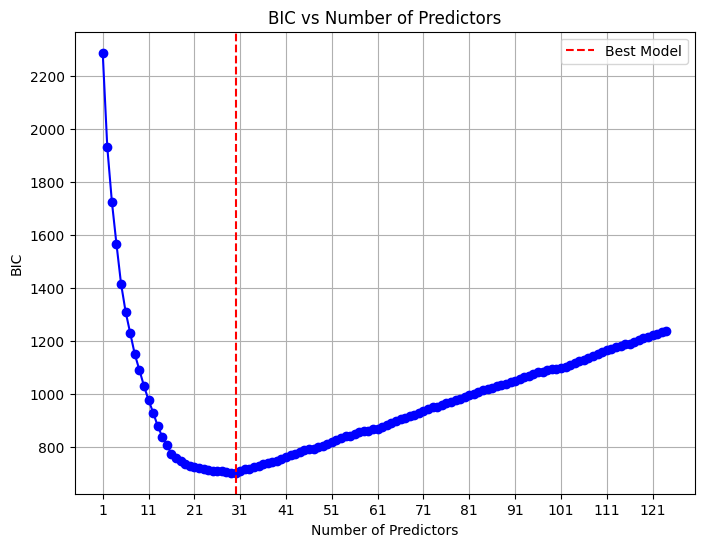

In [37]:
log_regression_bic(df=alzheimers_data_new_columns, predictors=predictors_2)

Doing Logistic regression based on dummy variable:

In [ ]:
#creating a dataframe with the dummy variable:
